<a href="https://colab.research.google.com/github/williammcintosh/CS510_DataEngineering_Assignments/blob/main/02_gather/CS510_Week_2_Data_Gathering_using_REST_APIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title

* CS520 Data Gathering Using REST API
* Will McIntosh

# Goals

1. Learn about REST APIs
2. Apply your knowledge to develop a simple weather application

## Questions

Then develop a simple Python program that answers these questions:

* “Is it raining in Portland, OR?”
* “Will it be raining when our class next meets?”


## Import Libraries

In [1]:
# import required modules
import requests, json
import datetime
import seaborn as sns
import pandas as pd
pd.set_option("display.max_columns", None)

## Get API Key

We get the API key in a safe way by mounting Google Drive and then pulling the api key from a save folder.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('/content/drive/MyDrive/CS510 - Data Engineering/API Keys/weather_api_key.txt', 'r') as file:
    WEATHER_API_KEY = file.read().strip()

## Helper Functions

In [4]:
def ConvertJSONtoDataFrame(x):
  new_dict = {}
  for key, value in x.items():
      if isinstance(value, list):
          new_dict.update({f'{key}_{i}': v for i, v in enumerate(value)})
      elif isinstance(value, dict):
          new_dict.update({f'{key}_{k}': v for k, v in value.items()})
      else:
          new_dict.update({key: value})
  df = pd.DataFrame.from_dict(new_dict, orient='index').transpose()
  return df


def GetWeatherDataFrame(city_name, call_type="weather"):
  base_url = f"http://api.openweathermap.org/data/2.5/{call_type}?"
  complete_url = base_url + "appid=" + WEATHER_API_KEY + "&q=" + city_name
  response = requests.get(complete_url)
  x = response.json()

  if call_type=="weather":
    return ConvertJSONtoDataFrame(x)

  forecasts = []
  for i in x['list']:
    forecasts.append(ConvertJSONtoDataFrame(i))

  fdf = pd.concat(forecasts).reset_index(drop=True)

  # Convert the 'dt_txt' column to datetime data type
  fdf['dt_txt'] = pd.to_datetime(fdf['dt_txt'])

  # Extract the date from the datetime object and create a new column 'date'
  fdf['date'] = fdf['dt_txt'].dt.date
  fdf['hour_of_day'] = fdf['dt_txt'].dt.hour.astype(int)
  fdf = fdf.rename({'rain_3h':'rain_inches'}, axis=1)

  return fdf

In [5]:
def plot_rain(next_class):
  rain = forecasts[forecasts['date'] == next_class].fillna(0)
  title = f"It's raining on {next_class}!" if any(x > 0.0 for x in rain['rain_inches']) else f"It's not raining on {next_class}!"
  ax = sns.lineplot(data=rain, y="rain_inches", x="hour_of_day")
  ax.set_title(title)
  ax.plot()

# Build Dataframes

## Question 1

Is it raining in Portland?

In [6]:
today = GetWeatherDataFrame("portland", call_type="weather")
today

,coord_lon,coord_lat,weather_0,base,main_temp,main_feels_like,main_temp_min,main_temp_max,main_pressure,main_humidity,visibility,wind_speed,wind_deg,clouds_all,dt,sys_type,sys_id,sys_country,sys_sunrise,sys_sunset,timezone,id,name,cod
0,-122.6762,45.5234,"{'id': 804, 'main': 'Clouds', 'description': '...",stations,285.29,284.44,283.84,286.47,1023,72,10000,4.63,170,100,1712614797,2,2008548,US,1712583391,1712630867,-25200,5746545,Portland,200


In [12]:
today.iloc[0]['weather_0']

{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}

In [7]:
print("It's raining today!" if today.iloc[0]['weather_0']['main'] == 'Rain' else "It's not raining today!")

It's not raining today!


## Question 2

Will it rain when we meet next class date?

In [8]:
forecasts = GetWeatherDataFrame("portland", call_type="forecast")
forecasts.head()

,dt,main_temp,main_feels_like,main_temp_min,main_temp_max,main_pressure,main_sea_level,main_grnd_level,main_humidity,main_temp_kf,weather_0,clouds_all,wind_speed,wind_deg,wind_gust,visibility,pop,sys_pod,dt_txt,rain_inches,date,hour_of_day
0,1712620800,284.39,283.53,282.56,284.39,1023,1023,1012,75,1.83,"{'id': 804, 'main': 'Clouds', 'description': '...",100,2.04,167,6.75,10000,0,d,2024-04-09 00:00:00,NaN,2024-04-09,0
1,1712631600,283.52,282.65,282.63,283.52,1023,1023,1012,78,0.89,"{'id': 804, 'main': 'Clouds', 'description': '...",100,2.49,189,7.93,10000,0,n,2024-04-09 03:00:00,NaN,2024-04-09,3
2,1712642400,282.59,281.14,282.59,282.59,1023,1023,1012,81,0,"{'id': 804, 'main': 'Clouds', 'description': '...",100,2.76,201,8.55,10000,0,n,2024-04-09 06:00:00,NaN,2024-04-09,6
3,1712653200,282.71,281.16,282.71,282.71,1022,1022,1012,85,0,"{'id': 804, 'main': 'Clouds', 'description': '...",100,2.96,208,8.8,10000,0,n,2024-04-09 09:00:00,NaN,2024-04-09,9
4,1712664000,282.28,281.01,282.28,282.28,1023,1023,1012,94,0,"{'id': 500, 'main': 'Rain', 'description': 'li...",100,2.41,208,7.92,10000,0.21,n,2024-04-09 12:00:00,0.23,2024-04-09,12


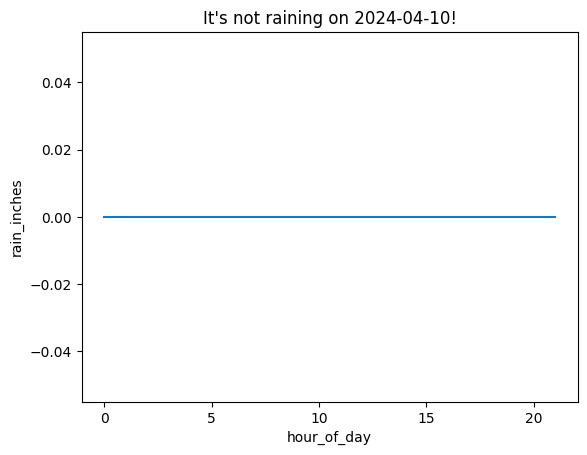

In [9]:
next_class = datetime.date(2024, 4, 10)
plot_rain(next_class)

It's not raining on the next day that we meet which is the 10th but it is raining on the 9th

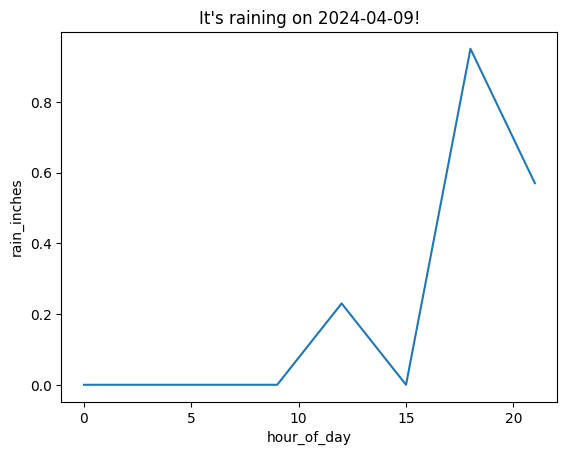

In [10]:
next_class = datetime.date(2024, 4, 9)
plot_rain(next_class)